In [213]:
import pandas as pd
import numpy as np
import classification_tools

import importlib
importlib.reload(classification_tools)

pd.set_option("display.max_columns",500)

import warnings
# suppress matplotlib warning in plot_confusion_matrix()
warnings.filterwarnings('ignore', message='FixedFormatter should only be used together with FixedLocator')



## Load Data


In [214]:
df_simd = pd.read_csv("data/simd_2020_ward.csv", index_col=0)
df_stopsearch = pd.read_csv("data/stop_search_clean.csv", index_col=0)
df_stopsearch = df_stopsearch.rename(columns={"Multi Member Ward":"ward_code"})

df_init = df_stopsearch.merge(right=df_simd, how="left", on="ward_code", validate="many_to_one")
df_init


,ward_code,Year,Month,Day of the Week,Time of the Day,Search Result,Nominal Age,Desc Drugs Found_Class B,Desc Drugs Found_Class C,Desc Drugs Found_Class A,Desc Off Weap Found_Other,Desc Other Items Found_Other,Desc Off Weap Found_Bladed Instrument,Desc Other Items Found_Firearms,Desc Off Weap Found_Pointed Article,Desc Other Items Found_Stolen Property,Desc Off Weap Found_Blunt Instrument,Desc Tobacco Found_Tobacco,Desc Other Items Found_Disposal Of Cash,Desc Alcohol Found_Beer,Desc Tobacco Found_Cigarette Papers,Desc Drugs Found_Nps,Desc Alcohol Found_Wine,Desc Alcohol Found_Spirits,Desc Other Items Found_Crossbows,Desc Other Items Found_Controlled Container,Desc Alcohol Found_Cider,Desc Other Items Found_Fireworks,Ethnic Group_2,Ethnic Group_3,Ethnic Group_4,Ethnic Group_5,Ethnic Group_6,Ethnic Group_7,Ethnic Group_8,Ethnic Group_9,Ethnic Group_10,Ethnic Group_11,Ethnic Group_12,Ethnic Group_13,Ethnic Group_14,Ethnic Group_15,Ethnic Group_16,Ethnic Group_17,Ethnic Group_18,Ethnic Group_19,Ethnic Group_20,Search Statute_CONTROLLED CONTAINERS - Sec 21 Criminal Law (Consolidation) (Scotland) Act 1995,Search Statute_CONTROLLLED ARTICLE OR SUBSTANCE - Sec 21 Criminal Law (Consolidation) (Scotland) Act 1995,Search Statute_Edinburgh Airport Byelaw 9(2) (Search in interest of public safety),"Search Statute_Sec 109(1) Copyright, Designs and Patents Act 1988 (Piracy and trademark offences etc)",Search Statute_Sec 11 of the Protection of Badgers Act 1992 (Wildlife Crime),Search Statute_Sec 11A of the Fireworks Act 2003,Search Statute_Sec 19 of the Wildlife and Countryside Act 1981,Search Statute_Sec 20 & 32 Police and Fire Reform (Scotland) Act 2012 (Other),Search Statute_Sec 20 & 32 Police and Fire Reform (Scotland) Act 2012 (Protection of Life),Search Statute_Sec 23(2) of the Misuse of Drugs Act 1971 (Drugs),Search Statute_Sec 23(3) Misuse Of Drugs Act 1971,Search Statute_Sec 23A of the Misuse of Drugs Act 1971 (Drugs),"Search Statute_Sec 24(1) Forgery and Counterfeiting Act, 1981 (Search for counterfeit money)",Search Statute_Sec 27 Deer (Scotland) Act 1996,Search Statute_Sec 289 Proceeds of Crime Act 2002 (Cash),Search Statute_Sec 4 of the Crossbows Act 1987,Search Statute_Sec 46(1) Firearms Act 1968,Search Statute_Sec 47(1) Firearms Act 1968 (Firearms),Search Statute_Sec 48(1) of the Criminal Law (Consolidation) (Scotland) Act 1995 (Offensive Weapon),Search Statute_Sec 49B of the Criminal Law (Consolidation) (Scotland) Act 1995 (Bladed Weapon/Offensive Weapon Schools),Search Statute_Sec 50 of the Criminal Law (Consolidation) (Scotland) Act 1995 (Bladed Weapon),Search Statute_Sec 53(1) of The Salmon and Freshwater Fisheries (Consolidation)(Scotland) Act 2003,Search Statute_Sec 60 Criminal Justice and Public Order Act 1994,Search Statute_Sec 60(1) Civic Government (Scotland) Act 1982 (Stolen Property),Search Statute_Sec 66 Criminal Justice (Scotland) Act 2016 (Removal of person),Search Statute_Sec 7 of the Wild Mammals (Scotland) Act 2002 (Wildlife Crime),Search Statute_Warrant - Other,Nominal Gender_Male,Nominal Physical Search Type_STRIP_IS,Nominal Physical Search Type_STRIP_OS,Command Code_2.0,Command Code_3.0,Division Code_3.0,Division Code_4.0,Division Code_5.0,Division Code_6.0,Division Code_7.0,Division Code_8.0,Division Code_9.0,Division Code_10.0,Division Code_11.0,Division Code_12.0,Division Code_13.0,Division Code_14.0,Area Command Code_3.0,Area Command Code_4.0,Area Command Code_6.0,Area Command Code_7.0,Area Command Code_8.0,Area Command Code_10.0,Area Command Code_11.0,Area Command Code_13.0,Area Command Code_14.0,Area Command Code_15.0,Area Command Code_16.0,Area Command Code_17.0,Area Command Code_18.0,Area Command Code_20.0,Area Command Code_21.0,Area Command Code_22.0,Area Command Code_24.0,Area Command Code_25.0,Area Command Code_27.0,Area Command Code_28.0,Area Command Code_29.0,Area Command Code_30.0,Area Command Code_31.0,Area Command Code_32.0,Area Command Code_34.0,Area Command Code_35.0,Area Command Code_38.

In [215]:
label = "Search Result"
s_labels = df_init[label]
df_init = df_init.drop(label, axis=1)
df_init = df_init.drop("ward_code", axis=1)

## Split Data

In [216]:
from sklearn.model_selection import train_test_split

X_train_init, X_val_init, y_train, y_val = train_test_split(df_init.copy(), s_labels.copy(), random_state=42, test_size=0.5)
X_test_init, X_val_init, y_test, y_val = train_test_split(X_val_init, y_val, random_state=42, test_size=0.5)

# Initial Model

Intuitively we might expect the stop and search data on its own to have some predictive power in the outcome of a stop and search. We'll first build this model and then try and improve upon it with the deprivation data.

We have a lot of features even in just the stop and search data - many of them one hot encodings of categorical variables. We will try and cut them down to what we think are the most useful initially.

- The date/time columns are difficult to work with, so we will drop those initially.
- Descriptions of items found are not predicting features, they would be targets and these can be our stretch goal for the project.
- The search statute and search reason could be useful but have a feeling they could be well correlated, can we explore this?
- Age, gender, ethnicity are definitely going to be important.
- Command Code, Area Command Code and Council code could be useful to link areas that are close together or operate under the same police command.

Initially, we'll start with just Age, Gender and Ethinicity


In [217]:
cols = X_train_init.columns[X_train_init.columns.str.contains("Ethnic Group.*", regex=True)].to_list()
cols += ["Nominal Age", "Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

model="Age, Ethnicity, Gender"
#don't apply regularisation: our features are not standaridezed and we want to avoid this to aid interpretation
models[model] = LogisticRegression(
    penalty="none"
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

Training score: 0.642
Validation Score:0.646


### Accuracy

In [218]:
positive = y_train[y_train==1].count()
negative = y_train[y_train==0].count()

print(f"Proportion of positive outcomes = {positive/(positive+negative)}")

Proportion of positive outcomes = 0.3578378668960327


Given that our data is split approximately 1/3 and 2/3 positive and negative outcomes, a 64% accuracy could mean our model is successful just always predicting negative.

We can check other metrics to explore how effective our model actually is:
- True positive rate and false negative rates
- AUC ROC score

### Confusion Matrix

True Negatives: 23,852
False Positives: 39
False Negatives: 13,270
True Positives: 43

True positive rate: 0.003230
False positive rate: 0.001632
Confusion matrix:
 [[23852    39]
 [13270    43]]


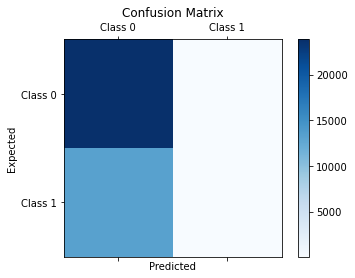

In [219]:
from sklearn.metrics import confusion_matrix

y_train_pred = classification_tools.predict_with_threshold(models[model], X_train, threshold=0.5)
conf_mat = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = conf_mat.ravel()

print("True Negatives: {:,}\nFalse Positives: {:,}\nFalse Negatives: {:,}\nTrue Positives: {:,}\n".format(tn,fp,fn,tp))

print("True positive rate: {:3f}".format(tp/(tp+fn)))
print("False positive rate: {:3f}".format(fp/(tn+fp)))

classification_tools.plot_confusion_matrix(conf_mat)


False positive rate is very low, this is good!

True positive rate is very low, this is bad.

The total propotion of positive predictions is very low, our model has simply learned to always predict negative. The ROC curve should backup the poor performance of our model.

### ROC Curve

#### Train

In [220]:
fig, auc = classification_tools.calc_roc(models[model], X_train, y_train)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

AUC ROC score: 0.520


#### Validate

In [221]:
fig, auc = classification_tools.calc_roc(models[model], X_val, y_val)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

AUC ROC score: 0.512


And it does. The area under the curve is barely over 50%.

Interpreting this: ethnicity, age and gender are not (or, rather, are only very midly) predictive of the outcome of a stop and search in Scotland.

What do they indidiual cofficients look like?

### Coefficients

In [222]:
coefficients = classification_tools.get_feature_weights(cols, models[model])


 6.90e-01: Ethnic Group_10
 6.83e-01: Ethnic Group_18
 4.34e-01: Ethnic Group_12
-3.58e-01: Ethnic Group_4
 3.50e-01: Ethnic Group_8
 3.18e-01: Ethnic Group_19
 2.97e-01: Ethnic Group_13
-2.85e-01: Ethnic Group_20
-2.13e-01: Ethnic Group_17
 2.07e-01: Ethnic Group_5
-1.66e-01: Ethnic Group_7
 1.37e-01: Nominal Gender_Male
-1.09e-01: Ethnic Group_15
-1.05e-01: Ethnic Group_9
 1.03e-01: Ethnic Group_2
-6.32e-02: Ethnic Group_6
 5.69e-02: Ethnic Group_11
 2.99e-02: Ethnic Group_16
 1.82e-02: Ethnic Group_3
 1.05e-02: Ethnic Group_14
-1.28e-04: Nominal Age


Age seems to be having very little effect, how does the model perform without it?

In [223]:
cols = X_train_init.columns[X_train_init.columns.str.contains("Ethnic Group.*", regex=True)].to_list()
cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

model="Ethnicity, Gender"

models[model] = LogisticRegression(
    penalty="none"
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

Training score: 0.642
Validation Score:0.646


In [224]:
fig, auc = classification_tools.calc_roc(models[model], X_train, y_train)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

AUC ROC score: 0.521


In [225]:
fig, auc = classification_tools.calc_roc(models[model], X_val, y_val)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

AUC ROC score: 0.511


In [226]:
coefficients = classification_tools.get_feature_weights(cols, models[model])

 1.06e+00: Ethnic Group_10
 5.49e-01: Ethnic Group_18
 4.54e-01: Ethnic Group_12
-3.51e-01: Ethnic Group_4
 3.43e-01: Ethnic Group_8
 3.07e-01: Ethnic Group_19
 2.89e-01: Ethnic Group_13
-2.88e-01: Ethnic Group_20
-2.43e-01: Ethnic Group_17
 2.05e-01: Ethnic Group_5
-1.89e-01: Ethnic Group_15
-1.87e-01: Ethnic Group_7
 1.38e-01: Nominal Gender_Male
 1.02e-01: Ethnic Group_2
-8.69e-02: Ethnic Group_9
 7.24e-02: Ethnic Group_11
-6.91e-02: Ethnic Group_6
 3.23e-02: Ethnic Group_16
 1.30e-02: Ethnic Group_3
 8.52e-03: Ethnic Group_14


AUC score is about the same, but the ROC graph is now consistently above the baseline of 0.5 and is less sensitive to threshold choice. This model should generally perform more consistently against real data.

What about Gender and Ethnicity Independently?

In [240]:
cols = X_train_init.columns[X_train_init.columns.str.contains("Ethnic Group.*", regex=True)].to_list()

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

model="Ethnicity"

models[model] = LogisticRegression(
    penalty="none"
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

fig, auc = classification_tools.calc_roc(models[model], X_val, y_val)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

print("Coefficents:")
coefficients = classification_tools.get_feature_weights(cols, models[model])

Training score: 0.642
Validation Score:0.646


AUC ROC score: 0.505
Coefficents:
 1.08e+00: Ethnic Group_10
 5.67e-01: Ethnic Group_18
 4.68e-01: Ethnic Group_12
-3.61e-01: Ethnic Group_4
 3.59e-01: Ethnic Group_8
 3.14e-01: Ethnic Group_19
 3.08e-01: Ethnic Group_13
-2.85e-01: Ethnic Group_20
-2.24e-01: Ethnic Group_17
 2.13e-01: Ethnic Group_5
-1.71e-01: Ethnic Group_7
-1.67e-01: Ethnic Group_15
 1.03e-01: Ethnic Group_2
-6.96e-02: Ethnic Group_9
-6.44e-02: Ethnic Group_6
 5.29e-02: Ethnic Group_11
 4.69e-02: Ethnic Group_16
 2.59e-02: Ethnic Group_14
 1.48e-02: Ethnic Group_3


In [241]:
cols = ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}

model="Gender"

models[model] = LogisticRegression(
    penalty="none"
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

fig, auc = classification_tools.calc_roc(models[model], X_val, y_val)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))
print("Coefficents:")
print("Gender: {:.3f}".format(models[model].coef_[0][0]))

Training score: 0.642
Validation Score:0.647


AUC ROC score: 0.508
Coefficents:
Gender: 0.147


It seems these two combined give the limited predictive power this model has, so we'll use this combination as a base to try and improve upon.

In [ ]:
model="Search Reason"
cols []

cols += X_train_init.columns[X_train_init.columns.str.contains("Ethnic Group.*", regex=True)].to_list()
cols += X_train_init.columns[X_train_init.columns.str.contains("Search Reason.*", regex=True)].to_list()
cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]
X_val = X_val_init[cols]

from sklearn.linear_model import LogisticRegression

models = {}



models[model] = LogisticRegression(
    penalty="none"
    )

models[model].fit(X_train, y_train)

print("Training score: {:.3f}\nValidation Score:{:.3f}".format(models[model].score(X_train, y_train), models[model].score(X_val, y_val)))

fig, auc = classification_tools.calc_roc(models[model], X_val, y_val)
fig.show()
print("AUC ROC score: {:.3f}".format(auc))

print("Coefficents:")
coefficients = classification_tools.get_feature_weights(cols, models[model])